In [53]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# Training data is 100 points in [-3,3] inclusive regularly spaced
num_points = 500
x = torch.linspace(-3, 3, num_points)
y = torch.linspace(-3, 3, num_points)
xrand = torch.randn(num_points,1)
yrand = torch.randn(num_points,1)

genfn = lambda x,y: torch.cos(2*x)*torch.cos(y) + torch.sin(x) # toy function

train_x = torch.cat((xrand.view(num_points,1),yrand.view(num_points,1)),dim=1) # concatenate training data
train_y = genfn(train_x[:,0],train_x[:,1])  # training function values

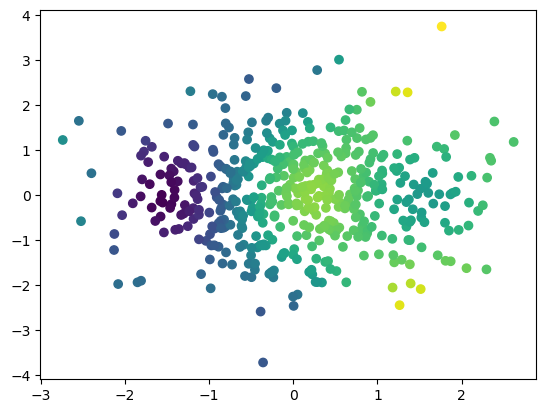

In [99]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

In [100]:
test_x_mat, test_y_mat = np.meshgrid(x, y)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)
test_z_mat = torch.round(genfn(test_x_mat,test_y_mat))

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_y = test_z_mat.view(-1)

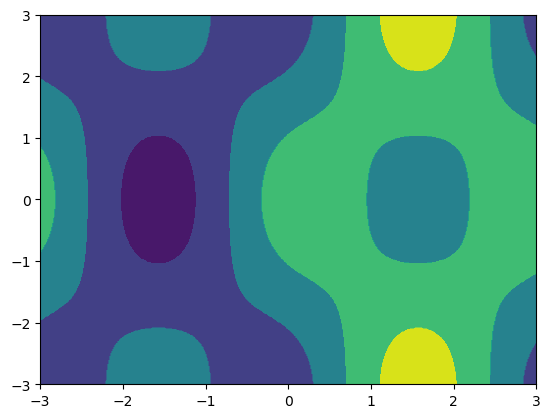

In [101]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_z_mat.numpy())

In [102]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [103]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.833   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.793   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.753   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.713   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.674   lengthscale: 0.909   noise: 0.513
Iter 6/50 - Loss: 0.635   lengthscale: 0.965   noise: 0.474
Iter 7/50 - Loss: 0.596   lengthscale: 1.019   noise: 0.437
Iter 8/50 - Loss: 0.558   lengthscale: 1.068   noise: 0.403
Iter 9/50 - Loss: 0.520   lengthscale: 1.107   noise: 0.370
Iter 10/50 - Loss: 0.481   lengthscale: 1.135   noise: 0.340
Iter 11/50 - Loss: 0.441   lengthscale: 1.150   noise: 0.312
Iter 12/50 - Loss: 0.399   lengthscale: 1.153   noise: 0.286
Iter 13/50 - Loss: 0.356   lengthscale: 1.146   noise: 0.261
Iter 14/50 - Loss: 0.313   lengthscale: 1.132   noise: 0.239
Iter 15/50 - Loss: 0.269   lengthscale: 1.113   noise: 0.218
Iter 16/50 - Loss: 0.225   lengthscale: 1.091   noise: 0.199
Iter 17/50 - Loss: 0.181   length

In [104]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    observed_pred_vals = observed_pred.loc

    # get mean values
    pred_means = model(test_x)
    pred_means = pred_means.loc
    pred_means_mat = pred_means.reshape((num_points,num_points))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower, upper = lower.reshape((num_points,num_points)), upper.reshape((num_points,num_points))

Text(0.5, 1.0, 'Predicted Mean')

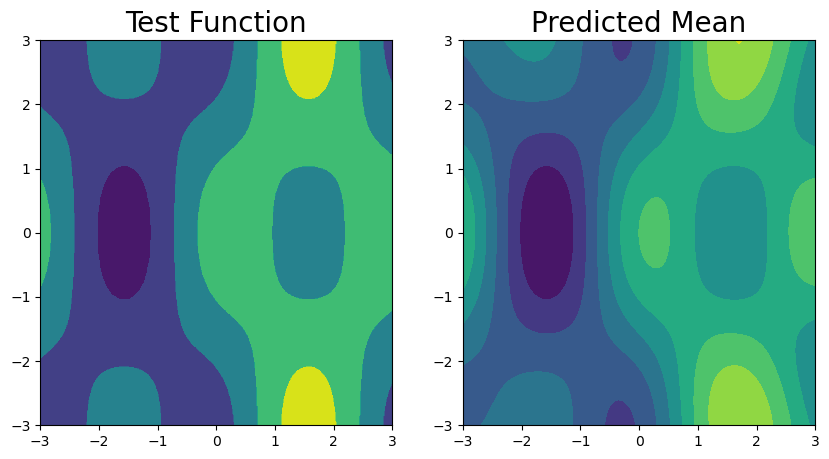

In [106]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_z_mat.numpy())
ax[0].set_title('Test Function', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.reshape((num_points,num_points)))
ax[1].set_title('Predicted Mean', fontsize=20)

In [144]:
# make slice at y = 0, for plotting mean + variance
eps = 0.1
k = 0
train_x_slice = []
train_y_slice = []
izero = []
upper_slice = []
lower_slice = []
mean_slice = []


for i in range(num_points):
    if torch.abs(train_x[i,1]) < eps:
        k += 1
        train_x_slice.append(train_x[i,0])
        train_y_slice.append(train_y[i])
        upper_slice.append(lower[i])
        lower_slice.append(lower[i])
        mean_slice.append(pred_means_mat[round(num_points/2),i])
        izero.append(k-1)

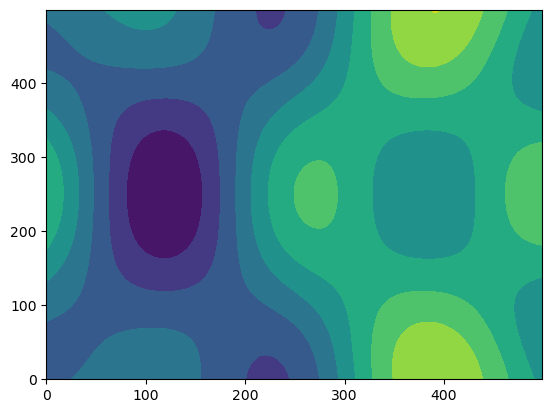

In [143]:
plt.contourf(pred_means_mat)

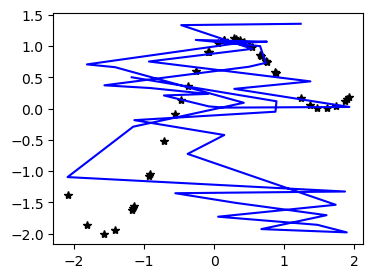

In [147]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    
    # Plot training data as black stars
    ax.plot(train_x_slice, train_y_slice, 'k*')
    # ax.plot(test_x_mat[250,:],test_z_mat[250,:])
    # # Plot predictive means as blue line
    ax.plot(train_x_slice, mean_slice, 'b')
    # # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    # ax.legend(['Observed Data', 'Mean', 'Confidence'])